Resume + Job + Label → THIS is supervised **learning**

In [19]:
import os
import re
import pandas as pd #Pandas is used to work with data easily (tables like Excel)
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity #It measures how similar two texts are.// Output: number between 0 and 1
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #A ready-made list of useless words like: the, is, and, in, to, of, for
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas()

sklearn ::::::It helps you build, train, test, and evaluate ML models easily

tqdm

Why it’s useful (especially for AI projects)

Long loops (cleaning many CVs)

Training steps

Applying preprocessing on big datasets

Instead of waiting blindly… you see progress

In [17]:
# Vérifiez dans Jupyter

print(pd.__version__)

3.0.0


In [6]:
RESUME_PATH ="C:/Users/Lenovo/Desktop/1P/training_data.csv/Resume.csv"  # change if different
JOB_PATH ="C:/Users/Lenovo/Desktop/1P/training_data.csv/training_data.csv"         # change if different
import csv 
resumes_df = pd.read_csv(RESUME_PATH,
                         on_bad_lines='skip')  # Skip problematic rows"""
resumes_df = pd.read_csv(RESUME_PATH,
                         quoting=csv.QUOTE_ALL,
                         escapechar='\\')
jobs_df = pd.read_csv(JOB_PATH)

print("Resumes shape:", resumes_df.shape)
print("Jobs shape:", jobs_df.shape)

Resumes shape: (2484, 4)
Jobs shape: (853, 5)


Raw CSV file (text) → Parsing → DataFrame (structured data)

NLTK = Natural Language Toolkit
It's a Python library for working with human language data (text).
import nltk

# Common NLTK operations:

# 1. **Tokenization** (split text into words)
from nltk.tokenize import word_tokenize
text = "I am a software engineer"
tokens = word_tokenize(text)  # ['I', 'am', 'a', 'software', 'engineer']

# 2. Remove **stopwords** (common words like 'a', 'the', 'is')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered = [w for w in tokens if w.lower() not in stop_words]

# 3. **Stemming** (reduce words to root form) "running", "runs", "ran"
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmer.stem('engineering')  # 'engin'

# 4. Part-of-speech tagging :Identify what type of word each is
nltk.pos_tag(tokens)  # [('I', 'PRP'), ('am', 'VBP'), ...]








***the lookup (in , not in ) is faster in sets than in lists***

SETS
# 1. No duplicates
s = {1, 2, 2, 3}  # {1, 2, 3}

# 2. No order (can't use indexing)
s[0]  # ❌ Error! Sets don't have positions

# 3. Fast membership testing
'apple' in my_set  # Very fast!

In [10]:
print (resumes_df.columns)

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='str')


In [8]:
import nltk
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

STOPWORDS = set(list(ENGLISH_STOP_WORDS)) - {"not", "no", "nor"}

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r"(\'re)", " are", text)
    text = re.sub(r"(\'s)", " is", text)
    text = re.sub(r"(\'ve)", " have", text)
    text = re.sub(r"(n\'t)", " not", text)
    text = re.sub(r"(\'ll)", " will", text)
    text = re.sub(r"(\'d)", " would", text)
    text = re.sub(r"(\'m)", " am", text)
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [tok for tok in text.split() if len(tok) > 2 and tok not in STOPWORDS] #the result is a list
    return " ".join(tokens) #" ".join() - Combine list into string with spaces

re : regular expresion  It's a built-in library for working with patterns in text



re.sub(pattern, replacement, text)
#      ↑        ↑            ↑
#      find /    replace with / in this text

In [11]:
print (resumes_df.columns)
print (resumes_df.dtypes)

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='str')
ID             int64
Resume_str       str
Resume_html      str
Category         str
dtype: object


In [21]:
possible_resume_cols = ['resume', 'resume_text', 'text', 'content', 'cv'] #condidates
possible_job_cols = ['job_description', 'description', 'jd', 'job', 'text']

def find_text_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    
    for c in df.columns:
        # Vérifier si c'est un type textuel
        if pd.api.types.is_string_dtype(df[c]) or pd.api.types.is_object_dtype(df[c]):
            return c
    
    raise ValueError("No suitable text column found. Update candidates or check dataframe columns.")

resume_col = find_text_column(resumes_df, possible_resume_cols)
job_col = find_text_column(jobs_df, possible_job_cols)

print("Using resume column:", resume_col)
print("Using job column:", job_col)

resumes_df['clean_text'] = resumes_df[resume_col].progress_apply(preprocess_text)
jobs_df['clean_text'] = jobs_df[job_col].progress_apply(preprocess_text)

resumes_df[[resume_col, 'clean_text']].head() # Double brackets [[...]] = select multiple columns

Using resume column: Resume_str
Using job column: job_description


100%|██████████| 853/853 [00:00<00:00, 1131.35it/s]


,Resume_str,clean_text
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,administrator marketing associate administrato...
1,"HR SPECIALIST, US HR OPERATIONS ...",specialist operations summary versatile media ...
2,HR DIRECTOR Summary Over 2...,director summary years experience recruiting p...
3,HR SPECIALIST Summary Dedica...,specialist summary dedicated driven dynamic ye...
4,HR MANAGER Skill Highlights ...,manager skill highlights skills department sta...


# WITHOUT parentheses = pass the function itself
resumes_df[resume_col].progress_apply(preprocess_text)
# progress_apply will CALL it later for each row

# WITH parentheses = call the function immediately
resumes_df[resume_col].progress_apply(preprocess_text())  # ❌ WRONG!
# This tries to call preprocess_text() NOW (no argument given → error)

# Pseudo-code of what progress_apply does:
def progress_apply(function):
    results = []
    for each_row in resumes_df[resume_col]:  # Loop through column
        result = function(each_row)           # Pass row to YOUR function
        results.append(result)
    return results

def preprocess_text(text):

resumes_df['clean_text']
 = resumes_df[resume_col].progress_appl(preprocess_text)     

progress_appl : shows a progress bar  with tqdm library

TF-IDF = Term Frequency - Inverse Document Frequency                 

It converts text into numbers by measuring:

How important a word is in a document

How rare that word is across all documents

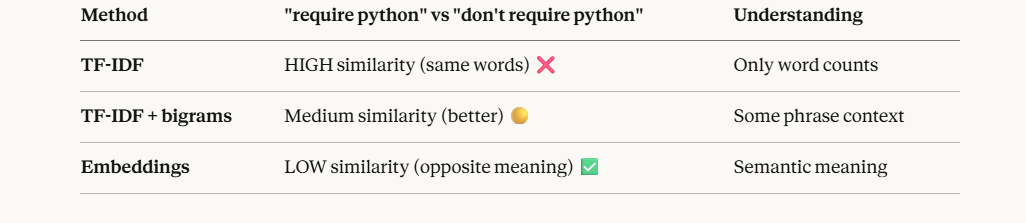

What does axis=1 mean?

In NumPy:

axis=0 → operate down the columns :move TOP to BOTTOM

axis=1 → operate across the rows :move LEFT to RIGHT

If you now train a model on this dataset…

The model will just learn:

“If similarity is high → output 1”

But YOU already defined that rule.

So the model is just learning your rule.(The model is just learning your similarity threshold)

It is not learning real matching patterns.




/////////////////////

similarity_matrix[i] → a row of similarities for resume i

similarity_matrix[i].argmax() → gives index of the best matching job
np.random.choice → pick a random negative (not the best match)

In [22]:
###############################CLEAN#####################################################
#the idf value is unique
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer


# Determine the minimum length for pairwise comparison
min_len = min(len(resumes_df), len(jobs_df))


############with embedding
#NaN is a float


from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
resume_texts = resumes_df['clean_text'].head(min_len).fillna('')
job_texts    = jobs_df['clean_text'].head(min_len).fillna('')

##elready with no nan so .tolist() is not mendatory 
resume_embeddings = model.encode(resume_texts)
job_embeddings    = model.encode(job_texts)

similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)



####the dataset problem 
import numpy as np


resumes_list = []
jobs_list = []
labels = []

for i in range(min_len):
    # 1️ Best match (positive)
    best_idx = similarity_matrix[i].argmax()
    resumes_list.append(resume_texts[i])
    jobs_list.append(job_texts[best_idx])
    labels.append(1)
    
    # 2️ Random negative (not the best)
    neg_choices = [j for j in range(min_len) if j != best_idx]
    neg_idx = np.random.choice(neg_choices)
    resumes_list.append(resume_texts[i])
    jobs_list.append(job_texts[neg_idx])
    labels.append(0)

# 3️ Create DataFrame
df = pd.DataFrame({
    "resume": resumes_list,
    "job": jobs_list,
    "label": labels
})

print(df.head())


 


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading

                                              resume  \
0  administrator marketing associate administrato...   
1  administrator marketing associate administrato...   
2  specialist operations summary versatile media ...   
3  specialist operations summary versatile media ...   
4  director summary years experience recruiting p...   

                                                 job  label  
0  job summary team member position responsible p...      1  
1  deep experience supporting toplevel executive ...      0  
2  position overview product sales analyst join t...      1  
3  job details job location college cleveland pos...      0  
4  human resources generalist aveda institutes lo...      1  


/////////////////////.sample(frac=1)  : frac=1: Specifies that you want to sample 100% of the rows. INDEXES ARE GONNA BE SHUFFLED TOO !!!!

In [24]:
df.sample(frac=1).reset_index(drop=True)

,resume,job,label
0,designer stylist summary high achieving sales ...,sales associate stylist stylists provide excel...,1
1,fitness specialist summary energetic personal ...,orangetheory fitness seven corners honors hold...,1
2,director business development executive profil...,want business make meaningful impact community...,1
3,director business development highlights micro...,not hiring coming months submit application co...,0
4,multimedia designer graphic designer portfolio...,applicable confirmation meet customer requirem...,0
...,...,...,...
1701,personnel assistant summary citizen authorized...,hey look opportunity,0
1702,specialist summary energetic administrative as...,youll main face contact norwalk furnitures war...,0
1703,manager information technology building automa...,send details resume work authorization status ...,1
1704,bartender summary hardworking reliable fitness...,mer brand represents hope healing mans deep re...,0


In [29]:
df['label'].value_counts()

label
1    853
0    853
Name: count, dtype: int64

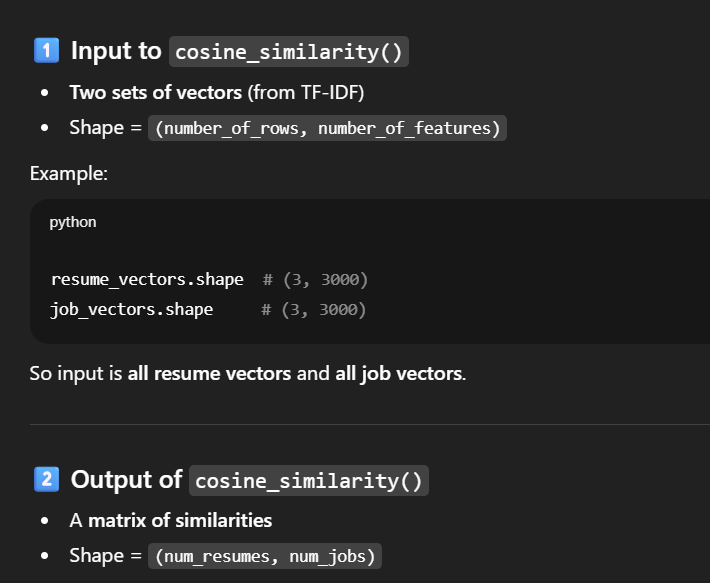

In [ ]:
#########################clear##################


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# ============================================
# STEP 1: Create the vectorizer
# ============================================
vectorizer = TfidfVectorizer(
    max_features=3000,      # Keep top 3000 words
    ngram_range=(1, 2),     # Use single words and 2-word phrases
    min_df=2,               # Ignore words appearing in less than 2 documents
    max_df=0.8              # Ignore words appearing in more than 80% of documents
)

# ============================================
# STEP 2: Combine all text (resumes + jobs)
# ============================================
all_text = pd.concat([
    resumes_df['clean_text'],
    jobs_df['clean_text']
])

# ============================================
# STEP 3: Fit vectorizer (learn vocabulary)
# ============================================
vectorizer.fit(all_text)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")


# View vocabulary
print(vectorizer.vocabulary_)
# {'python': 0, 'developer': 1, 'machine': 2, ...}

# View IDF scores
print(vectorizer.idf_)
# [0.69, 0.28, 0.69, ...]

# Get feature names (words in order)
print(vectorizer.get_feature_names_out())
# ['boot', 'developer', 'engineer', 'framework', 'java', ...]

# We have 5 documents total to learn IDF from:

Resume 1: "python developer"
Resume 2: "java developer"
Resume 3: "python machine learning engineer"
Job 1: "python machine learning required"
Job 2: "java developer needed"
```

---

## **Step 1: Calculate IDF for each word**

**Formula:** `IDF(word) = log(Total Documents / Documents containing word)`

### **Word frequencies across all documents:**

| Word | Appears in documents | Count | IDF Calculation | IDF Score |
|------|---------------------|-------|-----------------|-----------|
| python | Resume 1, Resume 3, Job 1 | 3/5 | log(5/3) = log(1.67) | **0.51** |
| developer | Resume 1, Resume 2, Job 2 | 3/5 | log(5/3) = log(1.67) | **0.51** |
| java | Resume 2, Job 2 | 2/5 | log(5/2) = log(2.5) | **0.92** |
| machine | Resume 3, Job 1 | 2/5 | log(5/2) = log(2.5) | **0.92** |
| learning | Resume 3, Job 1 | 2/5 | log(5/2) = log(2.5) | **0.92** |
| engineer | Resume 3 | 1/5 | log(5/1) = log(5) | **1.61** |
| required | Job 1 | 1/5 | log(5/1) = log(5) | **1.61** |
| needed | Job 2 | 1/5 | log(5/1) = log(5) | **1.61** |

**Key insight:**
- 'python', 'developer' appear in 3/5 docs → Lower IDF (0.51) - more common
- 'java', 'machine', 'learning' appear in 2/5 docs → Medium IDF (0.92)
- 'engineer', 'required', 'needed' appear in 1/5 docs → Higher IDF (1.61) - rare!

---

## **Step 2: Calculate TF-IDF for Resume 3**

**Resume 3:** "python machine learning engineer"

### **TF (Term Frequency) for Resume 3:**

Total words in Resume 3 = 4

| Word | Count | TF = Count / Total Words |
|------|-------|--------------------------|
| python | 1 | 1/4 = **0.25** |
| machine | 1 | 1/4 = **0.25** |
| learning | 1 | 1/4 = **0.25** |
| engineer | 1 | 1/4 = **0.25** |

### **TF-IDF = TF × IDF:**

| Word | TF | IDF | TF-IDF |
|------|-----|-----|--------|
| python | 0.25 | 0.51 | 0.25 × 0.51 = **0.128** |
| machine | 0.25 | 0.92 | 0.25 × 0.92 = **0.230** |
| learning | 0.25 | 0.92 | 0.25 × 0.92 = **0.230** |
| engineer | 0.25 | 1.61 | 0.25 × 1.61 = **0.403** |

### **Resume 3 vector (after normalization):**
```
Vocabulary order: [python, developer, java, machine, learning, engineer, required, needed]

Resume 3 raw: [0.128, 0, 0, 0.230, 0.230, 0.403, 0, 0]

# Normalize (make total magnitude = 1):
Resume 3 normalized: [0.22, 0, 0, 0.39, 0.39, 0.69, 0, 0]
                      ↑          ↑     ↑     ↑
                    python    machine learn engineer
```

---

## **Step 3: Calculate TF-IDF for Job 1**

**Job 1:** "python machine learning required"

### **TF for Job 1:**

Total words = 4

| Word | Count | TF |
|------|-------|-----|
| python | 1 | 0.25 |
| machine | 1 | 0.25 |
| learning | 1 | 0.25 |
| required | 1 | 0.25 |

### **TF-IDF:**

| Word | TF | IDF | TF-IDF |
|------|-----|-----|--------|
| python | 0.25 | 0.51 | **0.128** |
| machine | 0.25 | 0.92 | **0.230** |
| learning | 0.25 | 0.92 | **0.230** |
| required | 0.25 | 1.61 | **0.403** |

### **Job 1 vector (after normalization):**
```
Vocabulary order: [python, developer, java, machine, learning, engineer, required, needed]

Job 1 normalized: [0.22, 0, 0, 0.39, 0.39, 0, 0.69, 0]
                   ↑          ↑     ↑         ↑
                 python    machine learn  required
```

---

## **Step 4: Calculate Cosine Similarity**

**Formula:** `Similarity = (A · B) / (|A| × |B|)`

After normalization, it simplifies to: **dot product**
```
Resume 3: [0.22, 0,    0,    0.39, 0.39, 0.69, 0,    0]
Job 1:    [0.22, 0,    0,    0.39, 0.39, 0,    0.69, 0]

Dot product = (0.22×0.22) + (0×0) + (0×0) + (0.39×0.39) + (0.39×0.39) + (0.69×0) + (0×0.69) + (0×0)

= 0.0484 + 0 + 0 + 0.1521 + 0.1521 + 0 + 0 + 0

= 0.3526
```

**Similarity = 0.35 (35% match)**

---

## **Step 5: Why only 35%?**

Let's see what matched and what didn't:

| Word | Resume 3 | Job 1 | Match? |
|------|----------|-------|--------|
| python | ✓ (0.22) | ✓ (0.22) | ✅ Contributes: 0.22×0.22 = 0.048 |
| machine | ✓ (0.39) | ✓ (0.39) | ✅ Contributes: 0.39×0.39 = 0.152 |
| learning | ✓ (0.39) | ✓ (0.39) | ✅ Contributes: 0.39×0.39 = 0.152 |
| engineer | ✓ (0.69) | ✗ (0) | ❌ No contribution |
| required | ✗ (0) | ✓ (0.69) | ❌ No contribution |

**3 out of 4 words match, but 'engineer' and 'required' don't overlap → 35% similarity**

---

## **Compare with Resume 1:**

**Resume 1:** "python developer"
```
Resume 1 vector: [0.71, 0.71, 0, 0, 0, 0, 0, 0]
                  ↑     ↑
                python  dev

Job 1 vector:    [0.22, 0, 0, 0.39, 0.39, 0, 0.69, 0]

Similarity = (0.71×0.22) + (0.71×0) + ... = 0.156 + 0 = 0.156

In [28]:
df.to_csv("my_dataset.csv", index=False)
import os
print(os.getcwd())  # Affiche le dossier actuel





c:\Users\Lenovo\Downloads


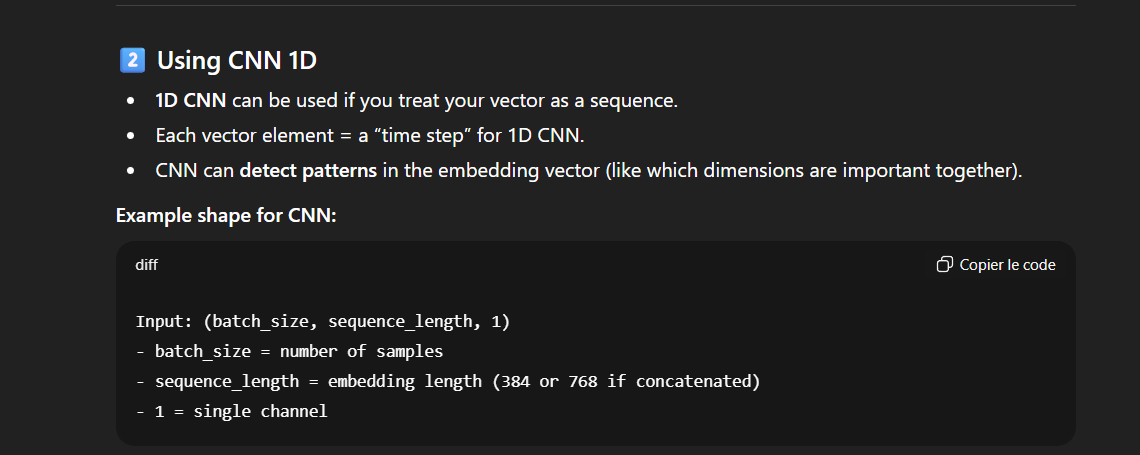

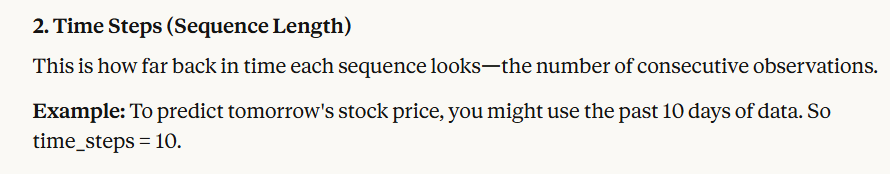